# Рекомендация тарифов

## Описание проекта

### Краткое описание

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

### Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.
* `сalls` — количество звонков,

* `minutes` — суммарная длительность звонков в минутах,

* `messages` — количество sms-сообщений,

* `mb_used` — израсходованный интернет-трафик в Мб,

* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

### План работы

1. Открываем датасет, изучаем общую информацию.

2. Разделяем данные на тренировочную, валидационную и тестовую выборки.

3. Исследуем разные модели, меняем гиперпараметры, выбираем самые эффективные.

4. Проверяем наши модели на тестовой выборке.

5. Общий вывод.

## Проект

### Откройте и изучите файл

In [1]:
# Импортируем необходимые библиотеки

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import time

In [2]:
# Сохраняем исходный датафрейм в переменной users.

pth1 = 'C:\\Users\\mpeat\\Desktop\\Practicum_Data_Science\\2 Modul\\project\\users_behavior.csv'
pth2 = 'https://code.s3.yandex.net/datasets/users_behavior.csv'
    
if os.path.exists(pth1):
    users = pd.read_csv(pth1)
else:
    users = pd.read_csv(pth2)

In [3]:
# Ознакомимся с данными
users.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Имеем датафрейм длинной 3214 строк. Пропуски отсутствуют, т.к. была ранее сделана предобработка.

Так как предобработка данных не требуется, то данный этап пропускаем.

**Вывод:** В исходном датафрейме имеем 3214 объектов(строк). Ключевым признаком является столбец `is_ultra`. 1 означает, что подключен тариф *ultra*, 0 - *smart*. Данный признак занесем в отдельную переменную *`target`*, все остальные - в *`features`*.

### Разбейте данные на выборки

Для проведения исследования необходимо разбит данные на 3 выборки: ***тренировочная, валидационная, тестовая***. Разобьем данные в пропорции ***3:1:1***.

In [5]:
# Выделяем признаки в отдельные переменные
target = users['is_ultra'] # ключевой признак
features = users.drop(['is_ultra'], axis=1) # остальные признаки

# Разбиваем данные на 3 выборки
features_train, features_notrain, target_train, target_notrain = train_test_split(features, target, test_size=0.4, random_state=1)
features_valid, features_test, target_valid, target_test = train_test_split(features_notrain, target_notrain, test_size=0.5, random_state=1)

In [6]:
# Проверим выборки
print(features_train.shape, target_train.shape,'\n',
      features_valid.shape, target_valid.shape,'\n',
      features_test.shape, target_test.shape)

(1928, 4) (1928,) 
 (643, 4) (643,) 
 (643, 4) (643,)


Выборки получились правильных размеров.

Вывод: В данном пункте методом **`train_test_split`** разделили данные на 3 выборки. В итоге имеем две одинаковые ***тестовую и валидациюнную*** выборки размером по 643 строк, и ***тренировочную выборку*** в 3 раза больше размером 1928 строк.

### Исследуйте модели

Для решения задачи, используем 3 модели машинного обучения: ***решающее дерево, случайный лес, логистическая регрессия***.

Для каждой модели подберем оптимальные гиперпараметры, и в замерим метрики качества и скорости.

In [7]:
# Решающее дерево

best_result_dt = 0
best_model_dt = None
best_depth_dt = 0
start_time = time.time()

for depth in range(1, 15):    
    model_dt = DecisionTreeClassifier(max_depth=depth, random_state=1)
    model_dt.fit(features_train, target_train)
    result = model_dt.score(features_valid, target_valid)
    
    if result > best_result_dt:
        best_result_dt = result
        best_model_dt = model_dt
        best_depth_dt = depth
        
print('Accuracy лучшей модели на валидационной выборке:', best_result_dt.round(3),
      '\nМаксимальная глубина:', best_depth_dt,
      '\nПотраченное время', round(time.time() - start_time, 3), 'c')

Accuracy лучшей модели на валидационной выборке: 0.796 
Максимальная глубина: 9 
Потраченное время 0.202 c


Итоговые результаты, видим перед своими глазами. Можно отметить неплохую точность и довольно высокую скорость инициализации.

In [8]:
# Случайный лес

best_result_rf = 0
best_model_rf = None
best_depth_rf = 0
best_est = 0
start_time = time.time()


for est in range(10, 51, 10):
    for depth in range(1, 15):    
        model_rf = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=1)
        model_rf.fit(features_train, target_train)
        result = model_rf.score(features_valid, target_valid)

        if result > best_result_rf:
            best_result_rf = result
            best_model_rf = model_rf
            best_depth_rf = depth
            best_est_rf = est

print('Accuracy лучшей модели на валидационной выборке:', best_result_rf.round(3),
      '\nКоличество деревьев', best_est_rf,
      '\nМаксимальная глубина:', best_depth_rf,
      '\nПотраченное время', round(time.time() - start_time, 3), 'с')

Accuracy лучшей модели на валидационной выборке: 0.804 
Количество деревьев 40 
Максимальная глубина: 11 
Потраченное время 15.578 с


В данном случае затратили большое количество времени на подбор оптимальной модели, больше 10 секунд.


Сократим диапазон количества деревьев с 50 до 20.

In [9]:
# Случайный лес 2

best_result_rf = 0
best_model_rf = None
best_depth_rf = 0
best_est = 0
start_time = time.time()


for est in range(10, 21, 10):
    for depth in range(1, 15):    
        model_rf = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=1)
        model_rf.fit(features_train, target_train)
        result = model_rf.score(features_valid, target_valid)

        if result > best_result_rf:
            best_result_rf = result
            best_model_rf = model_rf
            best_depth_rf = depth
            best_est_rf = est

print('Accuracy лучшей модели на валидационной выборке:', best_result_rf.round(3),
      '\nКоличество деревьев', best_est_rf,
      '\nМаксимальная глубина:', best_depth_rf,
      '\nПотраченное время', round(time.time() - start_time, 3), 'с')

Accuracy лучшей модели на валидационной выборке: 0.801 
Количество деревьев 10 
Максимальная глубина: 10 
Потраченное время 3.235 с


Сократили время инициализации оптимальной модели в 5 раз почти не потеряв в точности. Оставим данный результат как конечный.

In [10]:
# Логистическая регрессия

start_time = time.time()
model_lr = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1)
model_lr.fit(features_train, target_train)
result = model_rf.score(features_valid, target_valid)

print('Accuracy модели логистической регрессии на валидационной выборке:', result.round(3),
     '\nПотраченное время', round(time.time() - start_time, 3), 'c')

Accuracy модели логистической регрессии на валидационной выборке: 0.788 
Потраченное время 0.118 c


Модель логистической регрессии самая быстрая, так как в ней меньше всего гиперпараметров, но не самая точная.

**Вывод:** В ходе перебора гиперпаратметров, получили 3 оптимальные модели:
* Модель решающего дерева: качество - 79,6%, время на подбор - 0,176c;
* Модель случайного леса: качество - 80,1%, время на подбор - 2,227с;
* Модель логистической регрессии: качество - 79,8%, время на создание - 0,081с;

Модель случаного леса является самой точной, но одновременно самой медленной, напротив модель логистической регрессии самая быстрая и вторая по точности примерно такую же точность показала модель решающего дерева.

### Проверьте модель на тестовой выборке

Для тестирования выберем модель *`случайного леса`*, т.к. она показала лучший результат на валидации.

In [11]:
# Проверка лучшей модели на тестовой выборке

start_time = time.time()
res2 = best_model_rf.score(features_test, target_test)
duration2 = time.time() - start_time

print('Точность на тестовой выборке:', res2.round(3), '\nПродолжительность работы:', round(duration2, 5), 'c')

Точность на тестовой выборке: 0.81 
Продолжительность работы: 0.01099 c


**Вывод:** Для тестирования была выбрана модель *`случаного леса`*, которая показала лучший результат на валидации - **80,1%**. На тестовой выборке точность модели осталась примерно на том же уровне - **81%** (надо сделать ремарку, что в реальных задачах мы так проверить точность модели на тесте не сможем, но так как у нас известны правильные ответы, то мы проверим), что говорит о том что наша модель не переобучена и пригодна для дальнейшей работы.

### (бонус) Проверьте модели на адекватность

Для проверки моделей на адекватность, необходимо их точность сравнить с точностью, при случайном выборе значения ключевого признака. В теории у в ключевом признаке есть только 2 значения, 0 и 1, а значит вероятность получить то или иное значение при случайном выборе будет 0,5, следовательно точность угадывания тоже будет случайной на уровне 0,5. Чтобы не быть голословным, смоделируем модель, которая случайно выбирает значения.

Медианное значение: 0.49922239502332816
Максимальное значение: 0.5614307931570762
p-value для значения 0.55 и выше: 0.3 %


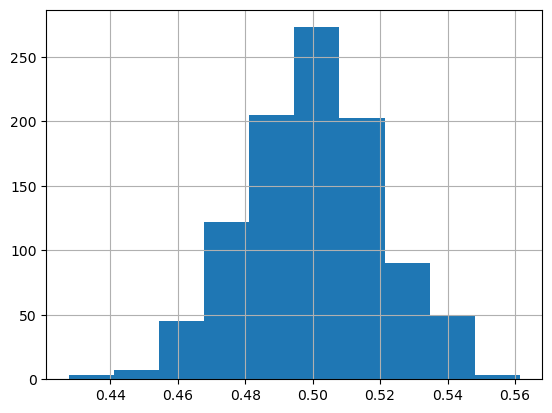

In [12]:
res = [] # сюда будем заносить значения точности модели в n-ой итерации

# Смоделируем эксперимент 1000 раз
for i in range(1000):
    target_test_random = pd.Series(np.random.randint(0, 2, target_test.shape[0]), index=target_test.index)    
    accuracy = accuracy_score(target_test_random, target_test)
    res.append(accuracy)
    
res_data = pd.Series(res) # превращаем список в Series
res_data.hist() # строим гистограмму
None

print('Медианное значение:', res_data.median()) # выводим медианное значение
print('Максимальное значение:', res_data.max()) # максимальное значение точности
print('p-value для значения 0.55 и выше:', res_data[res_data > 0.55].count() / 10, "%") 

In [13]:
res_data[res_data > 0.55].count() # отдельно выведем количество случаев с высокой точности из 1000

3

**Вывод:** Как видим, в среднем, при случаном случайная модель будет показывать точность около 0.50, максимальная точность будет в районе 0.55, и вероятность получить такое значение менее 1 процента или около него.

Минимальная точность, которую показали наши модели, в районе 0.75, что в полтора раза выше точности случайного выбора. Вероятность получить такую точность при случайном выборе настолько мала, что ей можно пренебречь, а значит, все получившиеся модели прошли тест на адекватность.

## Общий вывод

В ходе исследования, получили следующие выводы:

1. ***Загрузка данных.*** 
    
    В данных представлена информация о поведении клиентов и их тарифах. Ключевой признак - тариф находится в столбце `is_ultra`. Исходный размер - **3214 строк**. Предобработка данных не потребовалась так как была выполнена ранее, следовательно пропусков, дубликатов и других артефактов не обнаружено.


2. ***Разделение данных.***

    Данные были разделены на ***тренировочную, валидационную и тестовую*** выборки в пропорции **3:1:1**.


3. ***Исследование моделей.***

    Изучены разные модели, проведена настройка гиперпараметров. Самая точная модель - *`случайный лес`*, с точностью **80,1%**, но также самая медленная. Второй по точности оказалась модель *`решающего дерева`* с точностью **79,6%**. Модель *`логистической регрессии`* оказалась самой быстрой, но с точностью **79,8%**.
    
    
4. ***Проверка моделей.***

    На этапе тестирования *`модель случайного леса`* показала точность тот же уровень точности что и на валидации, что свидетельствует о ее непереобученности и пригодности для дальнейшей работы.
    
5. ***Проверка моделей на адекватность.***

    Все модели прошли проверку на адекватность, так как их точность значительно выше случайного выбора (0,5).
    
    
Анализ результатов позволяет сделать вывод, что лучшей моделью для рекомендации тарифов является случайный лес, обеспечивающий точность 81%.







## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
